In [138]:
import json
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [139]:
# Экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result


In [140]:
# Получим все даты с 2022-01-01 до 2023-01-31 во время 00:00:00 (например 2022-01-01 00:00:00)
def get_all_dates():
    dates = pd.date_range(start='2022-01-01 00:00:00', end='2023-01-31 00:00:00')
    return dates



In [141]:
# Скользящее среднее
def rolling_mean(series, value):
    return series.rolling(window=value).mean()

In [142]:
def make_series(df,
                category,
                is_exponential_smoothing=False,
                alpha=0.15,
                is_rolling_mean=False,
                rolling_value=20
                ):

    if isinstance(category, str):
        category = [category]

    # Выделим нужные данные
    data = df[df['category'].isin(category)]
    # Оставим только дату и нормированный кешбек
    data = data[['day', 'normalized_cashback']]

    # Получим все даты с 01.01.2022 по 01.01.2023
    dates = list(map(str, get_all_dates()))

    values = []
    for date in dates:
        # Если дата есть в данных, то добавим значение кешбека
        if date in data['day'].values:
            temp = data[data['day'] == date]['normalized_cashback'].values

        # Иначе добавим 0
        else:
            temp = np.array([0])

        values.append(np.mean(temp))

    values = np.array(values)

    if is_exponential_smoothing:
        values = exponential_smoothing(values, alpha)
    elif is_rolling_mean:
        values= rolling_mean(values, rolling_value)
    return values


In [143]:
# Тест Дики-Фуллера на стационарность
def test_stationarity(timeseries):
    timeseries = pd.Series(timeseries)

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    return dfoutput['p-value']

In [144]:
# Загрузим данные
ans_df = pd.read_csv('tasks/merch_cb_hack_8_9.csv')
df = pd.read_csv('data.csv')

with open('test_categories.json', 'r', encoding="utf-8") as file:
    categories = json.load(file)

organisations = ans_df['merchant_name'].unique()

# Отсортируем данные по именам и возрастании даты
ans_df = ans_df.sort_values(by=['merchant_name', 'day'])

5КармаNов
Results of Dickey-Fuller Test:
7.573868201860332e-05


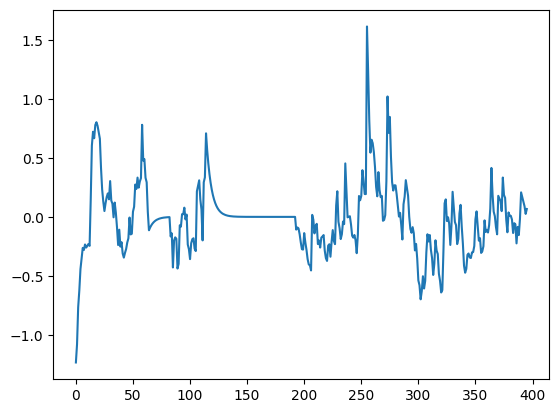

Bonafide
Results of Dickey-Fuller Test:
7.573868201860332e-05


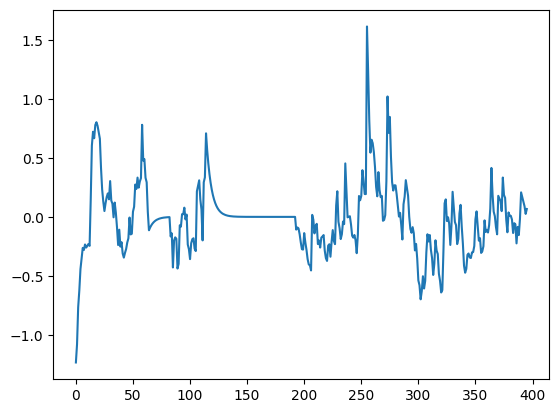

GLOBUS
Results of Dickey-Fuller Test:
0.000553956471216857


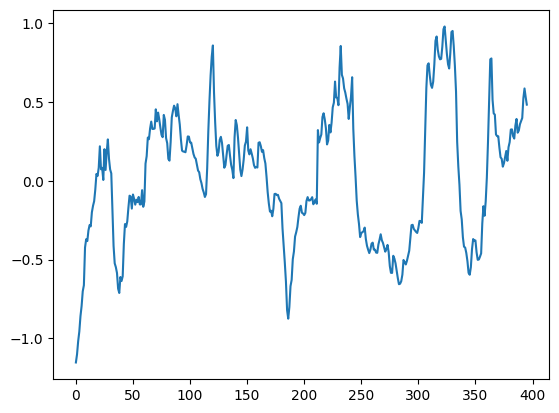

PREMIER
Results of Dickey-Fuller Test:
0.00040727710030396684


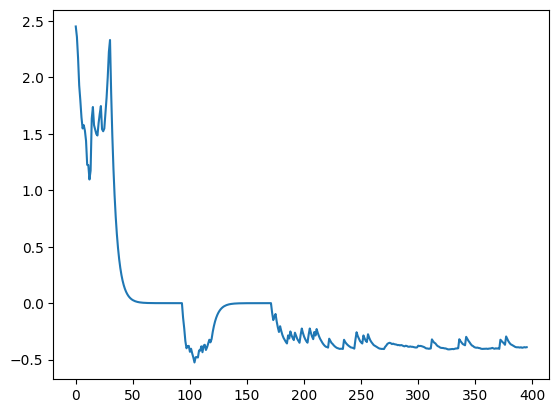

Vprok.ru Перекрёсток
Results of Dickey-Fuller Test:
0.000553956471216857


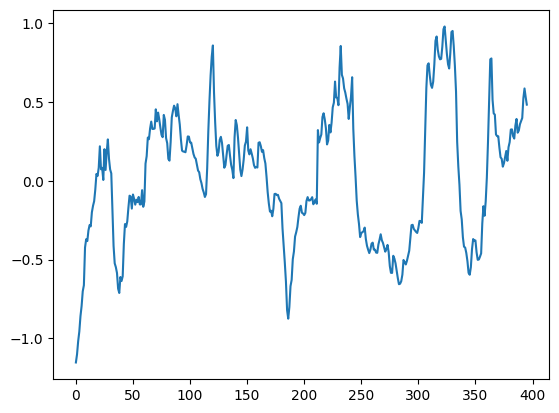

Много лосося
Results of Dickey-Fuller Test:
0.011860674329224745


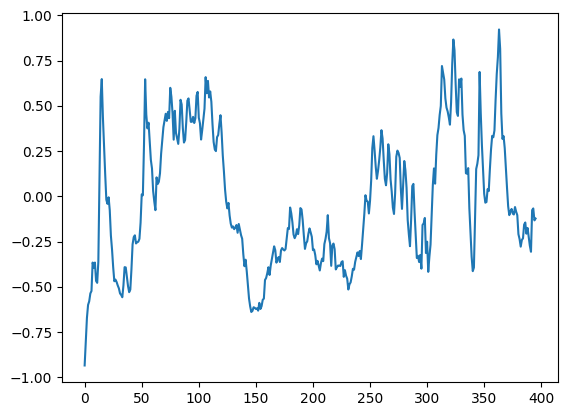

Пятёрочка
Results of Dickey-Fuller Test:
0.000553956471216857


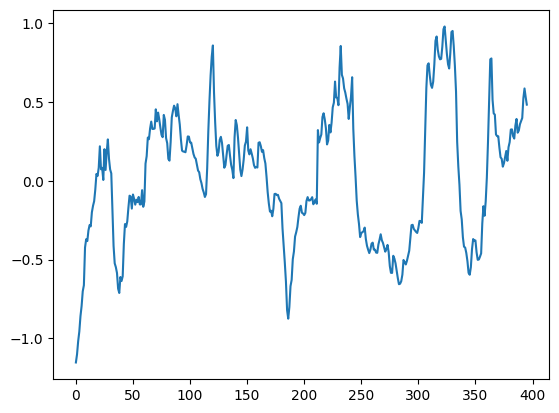

Ситидрайв
Results of Dickey-Fuller Test:
0.00010211334341173098


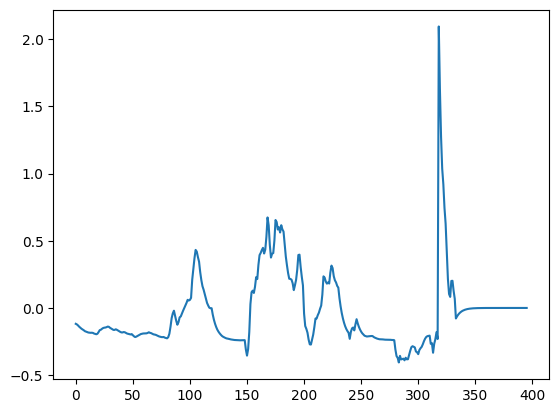

Столото
Results of Dickey-Fuller Test:
0.00024078010454536486


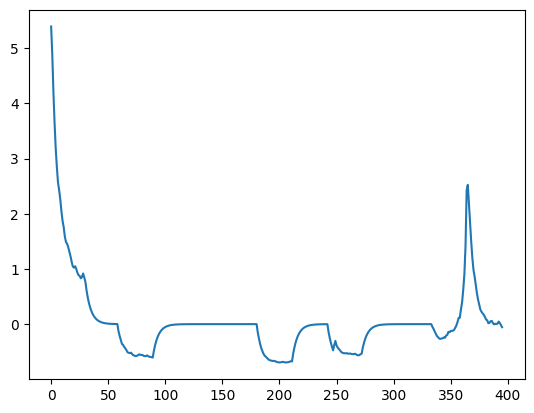

Читай-город
Results of Dickey-Fuller Test:
5.168362234325233e-06


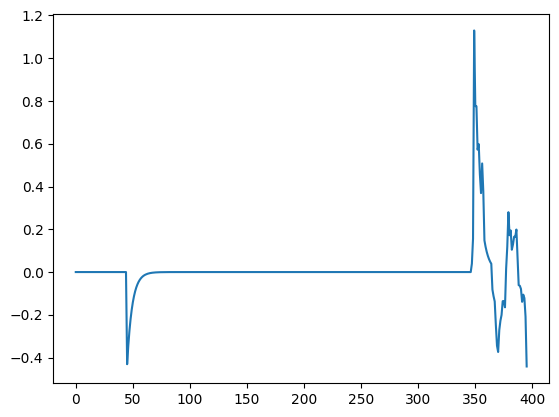

In [145]:
for organisation in organisations:
    print(organisation)
    series = make_series(df, categories[organisation], is_exponential_smoothing=True, alpha=0.2)
    print(test_stationarity(series))
    
    # Построим график
    plt.plot(series)
    plt.show()
    